# BATTLE OF NEIGHBORHOOD

# CHICAGO RESTAURANT RECOMMENDATION

### Introduction

City of Chicago, is the most populous city in the U.S. state of Illinois and the third most populous city in the United States. Chicago is the principal city of the Chicago metropolitan area, often referred to as Chicagoland. At nearly 10 million people, the metropolitan area is the third most populous in the nation. Chicago is an international hub for finance, culture, commerce, industry, education, technology, telecommunications, and transportation. Chicago lays claim to many regional specialties that reflect the city's ethnic and working-class roots. Included among these are its nationally renowned deep-dish pizza. 

As Chicago is known for its Pizza specialties, our customer is looking to open an upscale Pizza place in Chicago. The intention on this project is to collect and provide a data driven recommendation that can identify ideal location for opening an upscale Pizza place. Chicago Community areas are chosen for the ideal location. Core of Chicago is made of 77 communities, but we will focus on communities with larger population and higher per capita income as the restaurant is of a premium type. 


### Data Acquisition

This project will make use of the following data sources:

#### Chicago Community Area Census data
Data will be retrieved from Chicago open dataset https://www.chicago.gov/city/en/depts/dcd/supp_info/community_area_2000and2010censuspopulationcomparisons.html
The original data source contains population data for each Chicago community areas for the years 2000 and 2010 and its percentage difference. For our project we will retrieve 2010 population data for each community areas.

#### Chicago Community Per Capita Income data
Data will be retrieved from Chicago Data Portal
https://data.cityofchicago.org/Health-Human-Services/Per-Capita-Income/r6ad-wvtk
This dataset contains a selection of six socioeconomic indicators of public health significance by Chicago community area, for the years 2007 – 2011. Here we use the per capita income data for each community.

#### Chicago Top Venue Recommendations from FourSquare API
We will be using the FourSquare API to explore Chicago community areas. The Foursquare explore function will be used to get the most common venue categories in each community, and then use this feature to group the communities into clusters. The following information are retrieved, Venue ID, Venue Name, Venue Coordinates and Venue Category.


### Methodology

* Collect the Chicago Census data and Per capita income data.
* Wrangling the above data into single table and remove unnecessary features/attributes
* Identify the Lat/Long coordinates of Community areas
* Using FourSquare API find all venues for each Community areas.
* Cluster the community areas using K-means Clustering
* From the clustered community areas identify the best community to start the pizza place

### Data Wrangling

#### Installing & Importing the Modules. 

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
!conda install -c conda-forge tabula-py #Tabula to read PDF

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - tabula-py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    distro-1.4.0               |             py_0          19 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    tabula-py-1.4.1            |           py36_0        10.0 MB  conda-forge
    openjdk-11.0.1             |    h516909a_1016       175.5 MB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:       187.9 MB

The following NEW packages will be INSTALLED:

    distro:          1.4.0-py_0           conda-forge
    openjdk:   

In [3]:
!conda install -c conda-forge geocoder # Geocoder to provide Lat-Long coordinates

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

    geocoder: 1.38.1-py_1 conda-forge
    ratelim:  0.1.6-py_2  conda-forge


geocoder-1.38.1      | 53 KB     | ##################################### | 100% 
ratelim-0.1.6        | 6 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
!conda install -c conda-forge folium=0.5.0 --yes # Folium for charts

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         868 KB

The following NEW packages will be INSTALLED:

    altair:  3.2.0-py36_0 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


altair-3.2.0         | 770 KB    | #################################

##### Retrieving Census data. Tabula is used to retrieve the data from PDF

In [5]:
import tabula

In [6]:
df_1 = tabula.read_pdf("https://www.chicago.gov/content/dam/city/depts/zlup/Zoning_Main_Page/Publications/Census_2010_Community_Area_Profiles/Census_2010_and_2000_CA_Populations.pdf",  pages = 1, stream = True, area=(112.838, 78.03, 831.556, 580.635))
df_2 = tabula.read_pdf("https://www.chicago.gov/content/dam/city/depts/zlup/Zoning_Main_Page/Publications/Census_2010_Community_Area_Profiles/Census_2010_and_2000_CA_Populations.pdf",  pages = 2, stream = True, area=(112.838, 78.03, 831.556, 580.635))

In [7]:
df_1= df_1[['Num', 'Community Area', '2010']]
df_2= df_2[['Num', 'Community Area', '2010']]

In [8]:
df_2.dropna(subset=['Num'],inplace=True)
df_2.Num = df_2.Num.astype(int)

In [9]:
df_1.set_index('Num',inplace=True)
df_2.set_index('Num',inplace=True)

In [10]:
df_pop = pd.concat([df_1,df_2])

In [11]:
df_pop['2010'] = df_pop['2010'].str.replace(' ', '')

In [12]:
df_pop

,Community Area,2010
Num,,
1,Rogers Park,"54,991"
2,West Ridge,"71,942"
3,Uptown,"56,362"
4,Lincoln Square,"39,493"
5,North Center,"31,867"
6,Lake View,"94,368"
7,Lincoln Park,"64,116"
8,Near North Side,"80,484"
9,Edison Park,"11,187"


##### Retrieving Per capita income data

In [13]:
df_inc = pd.read_csv('https://data.cityofchicago.org/resource/jcxq-k9xf.csv')
df_inc.rename(columns={'ca':'Num'}, inplace=True)

In [14]:
df_inc

,Num,community_area_name,percent_of_housing_crowded,percent_households_below_poverty,percent_aged_16_unemployed,percent_aged_25_without_high_school_diploma,percent_aged_under_18_or_over_64,per_capita_income_,hardship_index
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0
5,6.0,Lake View,1.1,11.4,4.7,2.6,17.0,60058,5.0
6,7.0,Lincoln Park,0.8,12.3,5.1,3.6,21.5,71551,2.0
7,8.0,Near North Side,1.9,12.9,7.0,2.5,22.6,88669,1.0
8,9.0,Edison Park,1.1,3.3,6.5,7.4,35.3,40959,8.0
9,10.0,Norwood Park,2.0,5.4,9.0,11.5,39.5,32875,21.0


In [15]:
df_inc.dropna(subset=['Num'],inplace=True)
df_inc.Num = df_inc.Num.astype(int)

In [16]:
df_inc.set_index('Num',inplace=True)

In [17]:
df_inc= df_inc[['community_area_name', 'per_capita_income_']]

In [18]:
df_inc

,community_area_name,per_capita_income_
Num,,
1,Rogers Park,23939
2,West Ridge,23040
3,Uptown,35787
4,Lincoln Square,37524
5,North Center,57123
6,Lake View,60058
7,Lincoln Park,71551
8,Near North Side,88669
9,Edison Park,40959


##### Merging the data from two data frames

In [19]:
df = pd.merge(df_pop, df_inc, on='Num', how='inner')

In [20]:
df= df[['Community Area', '2010','per_capita_income_']]

In [21]:
df['Community Area'] = df['Community Area'].apply(lambda x: x.upper())

In [22]:
df

,Community Area,2010,per_capita_income_
Num,,,
1,ROGERS PARK,"54,991",23939
2,WEST RIDGE,"71,942",23040
3,UPTOWN,"56,362",35787
4,LINCOLN SQUARE,"39,493",37524
5,NORTH CENTER,"31,867",57123
6,LAKE VIEW,"94,368",60058
7,LINCOLN PARK,"64,116",71551
8,NEAR NORTH SIDE,"80,484",88669
9,EDISON PARK,"11,187",40959


##### Adding Lat-Long co-ordinates using geocoder

In [23]:
import geocoder

In [24]:
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chicago, United States'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [25]:
community = df['Community Area']    
coordinates = [get_latlng(community) for community in community.tolist()]

In [26]:
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])

In [27]:
df['Latitude'] = df_se_coordinates['Latitude']
df['Longitude'] = df_se_coordinates['Longitude']

In [28]:
df

,Community Area,2010,per_capita_income_,Latitude,Longitude
Num,,,,,
1,ROGERS PARK,"54,991",23939,41.999480,-87.692660
2,WEST RIDGE,"71,942",23040,41.981230,-87.660000
3,UPTOWN,"56,362",35787,41.975700,-87.689140
4,LINCOLN SQUARE,"39,493",37524,41.954110,-87.681420
5,NORTH CENTER,"31,867",57123,41.939820,-87.656820
6,LAKE VIEW,"94,368",60058,41.921840,-87.647440
7,LINCOLN PARK,"64,116",71551,41.900150,-87.634330
8,NEAR NORTH SIDE,"80,484",88669,42.007890,-87.813990
9,EDISON PARK,"11,187",40959,41.985470,-87.806110


In [29]:
df.at[77,'Latitude']= 41.983710
df.at[77,'Longitude']= -87.660110

In [30]:
df['2010'] = df['2010'].replace(',', '', regex=True).astype(int)

In [31]:
df

,Community Area,2010,per_capita_income_,Latitude,Longitude
Num,,,,,
1,ROGERS PARK,54991,23939,41.999480,-87.692660
2,WEST RIDGE,71942,23040,41.981230,-87.660000
3,UPTOWN,56362,35787,41.975700,-87.689140
4,LINCOLN SQUARE,39493,37524,41.954110,-87.681420
5,NORTH CENTER,31867,57123,41.939820,-87.656820
6,LAKE VIEW,94368,60058,41.921840,-87.647440
7,LINCOLN PARK,64116,71551,41.900150,-87.634330
8,NEAR NORTH SIDE,80484,88669,42.007890,-87.813990
9,EDISON PARK,11187,40959,41.985470,-87.806110


### Analysis

##### Plotting bar charts for Population and Per capita income

In [34]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

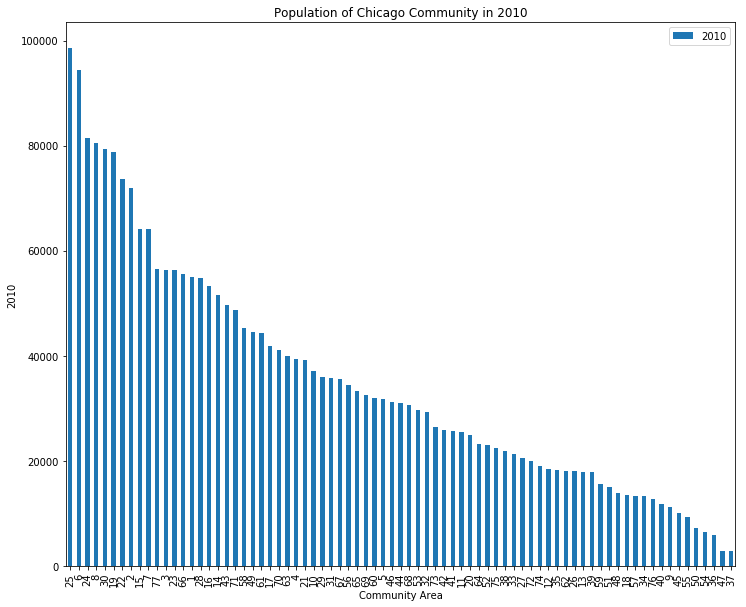

In [35]:
pop = df[['2010']]
pp = pop.sort_values('2010',ascending=False)

pp.plot(kind='bar', figsize=(12, 10))
plt.xlabel('Community Area') # add to x-label to the plot
plt.ylabel('2010') # add y-label to the plot
plt.title('Population of Chicago Community in 2010') # add title to the plot
plt.show()

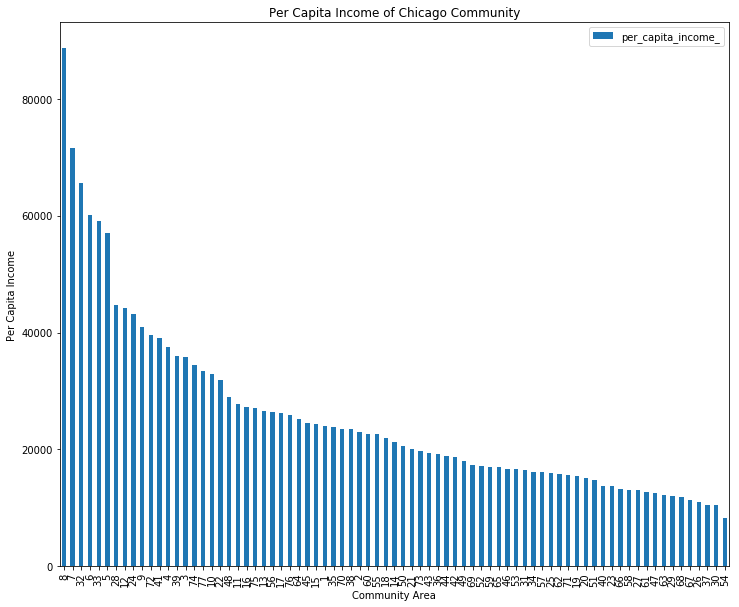

In [36]:
pop = df[['per_capita_income_']]
pp = pop.sort_values('per_capita_income_',ascending=False)

pp.plot(kind='bar', figsize=(12, 10))
plt.xlabel('Community Area') # add to x-label to the plot
plt.ylabel('Per Capita Income') # add y-label to the plot
plt.title('Per Capita Income of Chicago Community') # add title to the plot
plt.show()

##### Finding Mean and Median for Population and Per capita income attributes

In [37]:
Mean_pop = df['2010'].mean()
Median_pop = df['2010'].median()
Mean_pop, Median_pop

(35007.76623376623, 31028.0)

In [38]:
Mean_pci = df['per_capita_income_'].mean()
Median_pci = df['per_capita_income_'].median()
Mean_pci, Median_pci

(25563.16883116883, 21323.0)

##### Standardizing the values and Identifying Comunity areas suited for modelling 

In [39]:
df['pop_score'] = df['2010']/Median_pop*0.60
df['pci_score'] = df['per_capita_income_']/Median_pci*0.40

In [40]:
df['tot_score'] = df['pop_score']+df['pci_score']

In [41]:
df_1 = df.sort_values('tot_score',ascending=False)

In [42]:
df_1 = df_1.head(10)
df_1

,Community Area,2010,per_capita_income_,Latitude,Longitude,pop_score,pci_score,tot_score
Num,,,,,,,,
8,NEAR NORTH SIDE,80484,88669,42.007890,-87.813990,1.556349,1.663349,3.219699
6,LAKE VIEW,94368,60058,41.921840,-87.647440,1.824829,1.126633,2.951462
7,LINCOLN PARK,64116,71551,41.900150,-87.634330,1.239835,1.342231,2.582066
24,WEST TOWN,81432,43198,41.887740,-87.763920,1.574681,0.810355,2.385036
25,AUSTIN,98514,15957,41.877020,-87.730740,1.905002,0.299339,2.204341
22,LOGAN SQUARE,73595,31908,41.899070,-87.719470,1.423134,0.598565,2.021699
28,NEAR WEST SIDE,54881,44689,41.993736,-87.721421,1.061254,0.838325,1.899579
2,WEST RIDGE,71942,23040,41.981230,-87.660000,1.391169,0.432209,1.823379
19,BELMONT CRAGIN,78743,15461,41.928480,-87.734240,1.522683,0.290034,1.812717


In [43]:
##### Plotting the Community in the Chicago MAp

In [44]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Chicago are 41.8755616, -87.6244212.


In [45]:
import folium

In [47]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, community in zip(df_1['Latitude'], df_1['Longitude'], df_1['Community Area']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

##### Extracting Venue details using FourSquare API

In [48]:
CLIENT_ID = 'BJ14TA4MLJXXM1EJZH3KOZKYIYL5PKFYA5R0L45VUYI02QGT' # your Foursquare ID
CLIENT_SECRET = 'RU2ZKOEYTYLH5UHWR0HM2AZEA5DI20JK1PNCVIKJ3UUM1RFN' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BJ14TA4MLJXXM1EJZH3KOZKYIYL5PKFYA5R0L45VUYI02QGT
CLIENT_SECRET:RU2ZKOEYTYLH5UHWR0HM2AZEA5DI20JK1PNCVIKJ3UUM1RFN


##### Extracting 100 venues within the radius of 2000m using FourSquare API

In [49]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
chicago_venues = getNearbyVenues(names=df_1['Community Area'],
                                   latitudes=df_1['Latitude'],
                                   longitudes=df_1['Longitude']
                                  )

NEAR NORTH SIDE
LAKE VIEW
LINCOLN PARK
WEST TOWN
AUSTIN
LOGAN SQUARE
NEAR WEST SIDE
WEST RIDGE
BELMONT CRAGIN
LOOP


In [66]:
print(chicago_venues.shape)
chicago_venues.head()

(473, 7)


,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NEAR NORTH SIDE,42.00789,-87.81399,Tony's Italian Deli and Subs,42.002882,-87.816443,Deli / Bodega
1,NEAR NORTH SIDE,42.00789,-87.81399,Zia's Trattoria,42.002697,-87.816013,Italian Restaurant
3,NEAR NORTH SIDE,42.00789,-87.81399,Nick's Drive-In,42.012274,-87.807024,Greek Restaurant
4,NEAR NORTH SIDE,42.00789,-87.81399,Firewater Saloon,42.002468,-87.816378,Bar
8,NEAR NORTH SIDE,42.00789,-87.81399,Nonno Pino's,42.003132,-87.816886,Italian Restaurant


##### Filtering only the restaurants

In [69]:
restaurant = ['Mexican Restaurant', 'Sandwich Place', 'Pizza Place', 'Fast Food Restaurant', 'Coffee Shop', 'Bar', 'Donut Shop', 'Fried Chicken Joint', 'Chinese Restaurant', 'American Restaurant', 'Italian Restaurant', 'Bakery', 'Ice Cream Shop', 'Seafood Restaurant', 'Café', 'Hot Dog Joint', 'Breakfast Spot', 'Diner', 'Brewery', 'BBQ Joint', 'Restaurant', 'Burger Joint', 'Deli / Bodega', 'Sushi Restaurant', 'Thai Restaurant', 'Taco Place', 'Wings Joint', 'Sports Bar', 'Southern / Soul Food Restaurant', 'Asian Restaurant', 'Middle Eastern Restaurant', 'New American Restaurant', 'Korean Restaurant', 'Caribbean Restaurant', 'Vietnamese Restaurant', 'Latin American Restaurant', 'Dessert Shop', 'Indian Restaurant', 'Mediterranean Restaurant', 'Vegetarian / Vegan Restaurant', 'Greek Restaurant', 'Snack Place', 'Food Truck', 'African Restaurant', 'Food & Drink Shop', 'Steakhouse', 'Gastropub', 'Cuban Restaurant', 'Frozen Yogurt Shop', 'Japanese Restaurant', 'Gourmet Shop', 'Burrito Place', 'Cajun / Creole Restaurant', 'Filipino Restaurant', 'French Restaurant', 'Eastern European Restaurant', 'Beer Bar', 'South American Restaurant', 'Salad Place', 'Argentinian Restaurant', 'Fish & Chips Shop', 'Bagel Shop', 'Afghan Restaurant', 'Ethiopian Restaurant', 'Food Court', 'Beer Garden', 'Irish Pub', 'Bistro', 'Peruvian Restaurant', 'Ramen Restaurant', 'Smoke Shop', 'German Restaurant', 'Scandinavian Restaurant', 'Pakistani Restaurant', 'Dim Sum Restaurant', 'Noodle House', 'Chocolate Shop', 'Fondue Restaurant', 'Tex-Mex Restaurant', 'Cupcake Shop', 'Bubble Tea Shop', 'Taiwanese Restaurant', 'Molecular Gastronomy Restaurant', 'Brazilian Restaurant', 'Smoothie Shop', 'Hotpot Restaurant', 'Comfort Food Restaurant', 'Persian Restaurant', 'Moroccan Restaurant', 'Spanish Restaurant', 'Tapas Restaurant', 'Turkish Restaurant', 'Russian Restaurant', 'North Indian Restaurant', 'Szechuan Restaurant', 'Portuguese Restaurant', 'Indonesian Restaurant', 'Czech Restaurant', 'Empanada Restaurant', 'Malay Restaurant', 'Arepa Restaurant', 'Israeli Restaurant', 'Burmese Restaurant']

In [70]:
chicago_venues = chicago_venues[chicago_venues['Venue Category'].isin(restaurant)]

In [71]:
print(chicago_venues.shape)

(473, 7)


In [72]:
chicago_venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,
AUSTIN,25,25,25,25,25,25
BELMONT CRAGIN,55,55,55,55,55,55
LAKE VIEW,54,54,54,54,54,54
LINCOLN PARK,48,48,48,48,48,48
LOGAN SQUARE,50,50,50,50,50,50
LOOP,59,59,59,59,59,59
NEAR NORTH SIDE,56,56,56,56,56,56
NEAR WEST SIDE,26,26,26,26,26,26
WEST RIDGE,64,64,64,64,64,64


In [73]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 77 uniques categories.


In [74]:
chicago_venue_unique_count = chicago_venues['Venue Category'].value_counts().to_frame(name='Count')

In [75]:
chicago_venue_unique_count

,Count
Mexican Restaurant,27
Pizza Place,27
Coffee Shop,26
Sandwich Place,22
Italian Restaurant,22
Chinese Restaurant,21
Fast Food Restaurant,20
American Restaurant,17
Bar,16
Bakery,15


In [76]:
pizza = ['Pizza Place']
chicago_pizza = chicago_venues[chicago_venues['Venue Category'].isin(pizza)]
chicago_pizza_count = chicago_pizza['Community'].value_counts().to_frame(name='Count')

In [77]:
chicago_pizza_count

,Count
LAKE VIEW,5
LOOP,5
NEAR NORTH SIDE,3
BELMONT CRAGIN,3
LOGAN SQUARE,3
LINCOLN PARK,3
NEAR WEST SIDE,3
WEST RIDGE,1
WEST TOWN,1


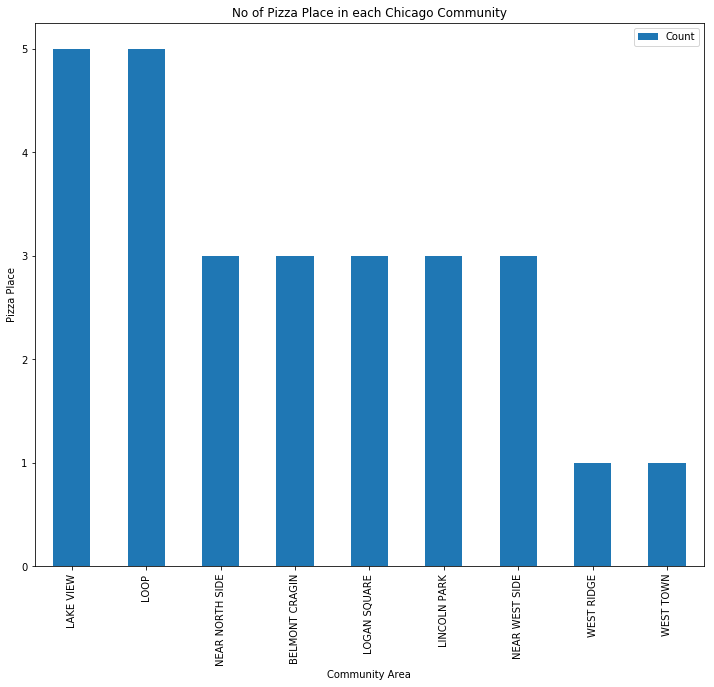

In [78]:
chicago_pizza_count.plot(kind='bar', figsize=(12, 10))
plt.xlabel('Community Area') # add to x-label to the plot
plt.ylabel('Pizza Place') # add y-label to the plot
plt.title('No of Pizza Place in each Chicago Community') # add title to the plot
plt.show()

##### One hot encoding and identifying most frequent venue

In [79]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Community'] = chicago_venues['Community'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Community,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Greek Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,North Indian Restaurant,Peruvian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,NEAR NORTH SIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NEAR NORTH SIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NEAR NORTH SIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NEAR NORTH SIDE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,NEAR NORTH SIDE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
chicago_onehot.shape

(473, 78)

In [81]:
chicago_grouped = chicago_onehot.groupby('Community').mean().reset_index()
chicago_grouped

,Community,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Greek Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,North Indian Restaurant,Peruvian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,AUSTIN,0.000000,0.000000,0.080000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.120000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,BELMONT CRAGIN,0.000000,0.000000,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.109091,0.000000,0.000000,0.018182,0.018182,0.054545,0.000000,0.000000,0.054545,0.000000,0.000000,0.018182,0.036364,0.036364,0.000000,0.000000,0.018182,0.000000,0.036364,0.018182,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.036364,0.000000,0.163636,0.000000,0.000000,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,0.018182,0.109091,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182
2,LAKE VIEW,0.000000,0.000000,0.018519,0.000000,0.000000,0.018519,0.018519,0.037037,0.018519,0.000000,0.000000,0.000000,0.018519,0.018519,0.018519,0.000000,0.037037,0.000000,0.000000,0.000000,0.055556,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.018519,0.018519,0.018519,0.018519,0.000000,0.000000,0.000000,0.000000,0.018519,0.018519,0.000000,0.018519,0.018519,0.000000,0.018519,0.111111,0.000000,0.018519,0.000000,0.018519,0.000000,0.000000,0.018519,0.018519,0.018519,0.000000,0.092593,0.000000,0.000000,0.000000,0.000000,0.018519,0.018519,0.000000,0.000000,0.000000,0.074074,0.018519,0.018519,0.000000,0.018519,0.018519,0.000000,0.000000,0.000000
3,LINCOLN PARK,0.000000,0.000000,0.083333,0.000000,0.000000,0.020833,0.000000,0.020833,0.020833,0.020833,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000,0.041667,0.000000,0.000000,0.000000,0.062500,0.000000,0.020833,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000,0.020833,0.000000,0.020833,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.020833,0.020833,0.020833,0.000000,0.000000,0.062500,0.000000,0.020833,0.062500,0.000000,0.104167,0.020833,0.000000,0.04

In [82]:
chicago_grouped.shape

(10, 78)

In [83]:
num_top_venues = 5

for hood in chicago_grouped['Community']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Community'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AUSTIN----
                  venue  freq
0  Fast Food Restaurant  0.20
1        Sandwich Place  0.12
2   Fried Chicken Joint  0.12
3   American Restaurant  0.08
4            Food Truck  0.04


----BELMONT CRAGIN----
                venue  freq
0  Mexican Restaurant  0.16
1                 Bar  0.11
2      Sandwich Place  0.11
3             Brewery  0.05
4                Café  0.05


----LAKE VIEW----
                venue  freq
0  Italian Restaurant  0.11
1         Pizza Place  0.09
2    Sushi Restaurant  0.07
3         Coffee Shop  0.06
4        Cupcake Shop  0.04


----LINCOLN PARK----
                     venue  freq
0               Restaurant  0.10
1               Steakhouse  0.10
2      American Restaurant  0.08
3              Pizza Place  0.06
4  New American Restaurant  0.06


----LOGAN SQUARE----
                venue  freq
0  Mexican Restaurant  0.12
1      Sandwich Place  0.10
2          Donut Shop  0.08
3         Pizza Place  0.06
4                 Bar  0.06


----LOOP--

In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['Community'] = chicago_grouped['Community']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head(10)

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AUSTIN,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,American Restaurant,Seafood Restaurant,Mexican Restaurant,Caribbean Restaurant,Food Truck,Burrito Place,Restaurant
1,BELMONT CRAGIN,Mexican Restaurant,Bar,Sandwich Place,Café,Brewery,Pizza Place,Coffee Shop,Latin American Restaurant,Taco Place,Diner
2,LAKE VIEW,Italian Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Dessert Shop,Cupcake Shop,Bakery,Café,Mediterranean Restaurant,Indonesian Restaurant
3,LINCOLN PARK,Restaurant,Steakhouse,American Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Café
4,LOGAN SQUARE,Mexican Restaurant,Sandwich Place,Donut Shop,Fast Food Restaurant,Bar,Latin American Restaurant,Pizza Place,Dessert Shop,Hot Dog Joint,Ice Cream Shop
5,LOOP,Chinese Restaurant,Pizza Place,Mexican Restaurant,Asian Restaurant,Burger Joint,Cajun / Creole Restaurant,Italian Restaurant,Dessert Shop,Korean Restaurant,Dim Sum Restaurant
6,NEAR NORTH SIDE,Italian Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Breakfast Spot,Pizza Place,Bakery,American Restaurant,Sushi Restaurant,Deli / Bodega
7,NEAR WEST SIDE,Coffee Shop,Pizza Place,Ice Cream Shop,Korean Restaurant,Afghan Restaurant,Burger Joint,Fast Food Restaurant,Fried Chicken Joint,Vietnamese Restaurant,Hot Dog Joint
8,WEST RIDGE,Vietnamese Restaurant,Coffee Shop,Breakfast Spot,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Bar,Italian Restaurant
9,WEST TOWN,Fast Food Restaurant,Donut Shop,American Restaurant,Seafood Restaurant,BBQ Joint,Sandwich Place,Coffee Shop,Fried Chicken Joint,Ice Cream Shop,African Restaurant


In [86]:
chicago_grouped.head()

,Community,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bistro,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Greek Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,North Indian Restaurant,Peruvian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,AUSTIN,0.0,0.0,0.080000,0.000000,0.04,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.04,0.000000,0.0,0.04,0.000000,0.040000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.040000,0.000000,0.0,0.200000,0.0,0.000000,0.000000,0.040000,0.000000,0.12,0.0,0.0,0.000000,0.000000,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.040000,0.000000,0.120000,0.040000,0.000000,0.00,0.040000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,BELMONT CRAGIN,0.0,0.0,0.018182,0.018182,0.00,0.000000,0.000000,0.000000,0.109091,0.000000,0.0,0.018182,0.018182,0.054545,0.000000,0.00,0.054545,0.0,0.00,0.018182,0.036364,0.036364,0.000000,0.00,0.018182,0.0,0.036364,0.018182,0.018182,0.0,0.018182,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.018182,0.018182,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.018182,0.000000,0.036364,0.000000,0.163636,0.0,0.000000,0.000000,0.000000,0.000000,0.054545,0.0,0.000000,0.018182,0.109091,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.036364,0.0,0.000000,0.000000,0.0,0.000000,0.018182
2,LAKE VIEW,0.0,0.0,0.018519,0.000000,0.00,0.018519,0.018519,0.037037,0.018519,0.000000,0.0,0.000000,0.018519,0.018519,0.018519,0.00,0.037037,0.0,0.00,0.000000,0.055556,0.000000,0.037037,0.00,0.037037,0.0,0.000000,0.018519,0.000000,0.0,0.000000,0.0,0.018519,0.018519,0.018519,0.018519,0.00,0.0,0.0,0.000000,0.018519,0.018519,0.0,0.018519,0.018519,0.0,0.018519,0.111111,0.000000,0.018519,0.000000,0.018519,0.000000,0.0,0.018519,0.018519,0.018519,0.000000,0.092593,0.0,0.000000,0.000000,0.000000,0.018519,0.018519,0.00,0.000000,0.000000,0.074074,0.018519,0.018519,0.0,0.018519,0.018519,0.0,0.000000,0.000000
3,LINCOLN PARK,0.0,0.0,0.083333,0.000000,0.00,0.020833,0.000000,0.020833,0.020833,0.020833,0.0,0.000000,0.000000,0.000000,0.020833,0.00,0.041667,0.0,0.00,0.000000,0.062500,0.000000,0.020833,0.00,0.020833,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.020833,0.000000,0.020833,0.0,0.020833,0.000000,0.0,0.000000,0.062500,0.000000,0.000000,0.020833,0.020833,0.020833,0.0,0.000000,0.062500,0.000000,0.020833,0.062500,0.0,0.104167,0.020833,0.000000,0.041667,0.000000,0.00,0.000000,0.104167,0.041667,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.020833,0.000000
4,LOGAN SQUARE,0.0,0.0,0.020000,0.000000,0.00,0.000000,0.000000,0.020000,0.060000,0.000000,0.0,0.020000,0.020000,0.000000,0.020000,0.00,0.020000,0.0,0.02,0.000000,0.020000,0.000000,0.000000,0.02,0.040000,0.0,0.000000,0.080000,0.000000,0.0,0.060000,0.0,0.000000,0.000000,0.00

### Predictive Modeling

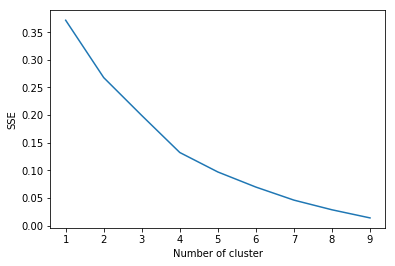

In [87]:
chicago_grouped_clustering = chicago_grouped.drop('Community', 1)
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(chicago_grouped_clustering)
    kmeans.labels_[0:10] 
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [88]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 1, 1, 2, 0, 1, 1, 1, 3], dtype=int32)

In [89]:
# add clustering labels
chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = df_1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Community'), on='Community Area')

chicago_merged.head() # check the last columns!

,Community Area,2010,per_capita_income_,Latitude,Longitude,pop_score,pci_score,tot_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Num,,,,,,,,,,,,,,,,,,,
8,NEAR NORTH SIDE,80484,88669,42.00789,-87.81399,1.556349,1.663349,3.219699,1,Italian Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Breakfast Spot,Pizza Place,Bakery,American Restaurant,Sushi Restaurant,Deli / Bodega
6,LAKE VIEW,94368,60058,41.92184,-87.64744,1.824829,1.126633,2.951462,1,Italian Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Dessert Shop,Cupcake Shop,Bakery,Café,Mediterranean Restaurant,Indonesian Restaurant
7,LINCOLN PARK,64116,71551,41.90015,-87.63433,1.239835,1.342231,2.582066,1,Restaurant,Steakhouse,American Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Café
24,WEST TOWN,81432,43198,41.88774,-87.76392,1.574681,0.810355,2.385036,3,Fast Food Restaurant,Donut Shop,American Restaurant,Seafood Restaurant,BBQ Joint,Sandwich Place,Coffee Shop,Fried Chicken Joint,Ice Cream Shop,African Restaurant
25,AUSTIN,98514,15957,41.87702,-87.73074,1.905002,0.299339,2.204341,3,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,American Restaurant,Seafood Restaurant,Mexican Restaurant,Caribbean Restaurant,Food Truck,Burrito Place,Restaurant


In [95]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community Area'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [91]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Community Area,pop_score,pci_score,tot_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Num,,,,,,,,,,,,,,,
32,LOOP,0.566256,1.229208,1.795464,0,Chinese Restaurant,Pizza Place,Mexican Restaurant,Asian Restaurant,Burger Joint,Cajun / Creole Restaurant,Italian Restaurant,Dessert Shop,Korean Restaurant,Dim Sum Restaurant


In [92]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Community Area,pop_score,pci_score,tot_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Num,,,,,,,,,,,,,,,
8,NEAR NORTH SIDE,1.556349,1.663349,3.219699,1,Italian Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Breakfast Spot,Pizza Place,Bakery,American Restaurant,Sushi Restaurant,Deli / Bodega
6,LAKE VIEW,1.824829,1.126633,2.951462,1,Italian Restaurant,Pizza Place,Sushi Restaurant,Coffee Shop,Dessert Shop,Cupcake Shop,Bakery,Café,Mediterranean Restaurant,Indonesian Restaurant
7,LINCOLN PARK,1.239835,1.342231,2.582066,1,Restaurant,Steakhouse,American Restaurant,Pizza Place,Coffee Shop,Italian Restaurant,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Café
28,NEAR WEST SIDE,1.061254,0.838325,1.899579,1,Coffee Shop,Pizza Place,Ice Cream Shop,Korean Restaurant,Afghan Restaurant,Burger Joint,Fast Food Restaurant,Fried Chicken Joint,Vietnamese Restaurant,Hot Dog Joint
2,WEST RIDGE,1.391169,0.432209,1.823379,1,Vietnamese Restaurant,Coffee Shop,Breakfast Spot,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Bar,Italian Restaurant


In [93]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Community Area,pop_score,pci_score,tot_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Num,,,,,,,,,,,,,,,
22,LOGAN SQUARE,1.423134,0.598565,2.021699,2,Mexican Restaurant,Sandwich Place,Donut Shop,Fast Food Restaurant,Bar,Latin American Restaurant,Pizza Place,Dessert Shop,Hot Dog Joint,Ice Cream Shop
19,BELMONT CRAGIN,1.522683,0.290034,1.812717,2,Mexican Restaurant,Bar,Sandwich Place,Café,Brewery,Pizza Place,Coffee Shop,Latin American Restaurant,Taco Place,Diner


In [94]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[0] + list(range(5, chicago_merged.shape[1]))]]

,Community Area,pop_score,pci_score,tot_score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Num,,,,,,,,,,,,,,,
24,WEST TOWN,1.574681,0.810355,2.385036,3,Fast Food Restaurant,Donut Shop,American Restaurant,Seafood Restaurant,BBQ Joint,Sandwich Place,Coffee Shop,Fried Chicken Joint,Ice Cream Shop,African Restaurant
25,AUSTIN,1.905002,0.299339,2.204341,3,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,American Restaurant,Seafood Restaurant,Mexican Restaurant,Caribbean Restaurant,Food Truck,Burrito Place,Restaurant


### Results & Discussion

* In the First cluster, we have ‘Loop’ which has 5 Pizza places in that Community. Also, it is one of the most common venue in that community.  There are lot of competition in this cluster and it is not recommended to open the Pizza place here.

* In the second cluster, we have 5 community places. These community places have higher Per capita income and larger population compared to other clusters. Their eating pattern and preference are similar. This cluster can be viewed as a potential cluster to open a Pizza place.  Out of these 5 community areas ‘West Ridge’ doesn’t have a Pizza place in the most common venue. Hence, we recommend ‘West Ridge’ as a potential candidate for opening the Pizza place.

* In the third cluster, we have ‘Logan Square’ and ‘Bellmont Cragin’. This cluster prefer Mexican restaurant over Pizza place as seen in the table. We can ignore this cluster

* In the fourth cluster, we have ‘West Town’ and ‘Austin’. In this cluster Pizza is not the preferred food. We don’t have any Pizza place or Italian restaurant in the top 10 common venue.  We can ignore this cluster too.


### Conclusion

This capstone project provides us a small glimpse of how real-life data-science projects look like. We have used python libraries to extract the data, used Foursquare API to explore the common Venues and used K-Means clustering to cluster and identify the best community area as a potential candidate for Pizza place set up. For setup of other restaurants like Chinese restaurants, demographic data can be used to identify the community areas with respective demographic majority and then cluster the community. 